In [1]:
import pandas as pd
import numpy as np
import random
import ray
from itertools import combinations
import torch.nn as nn
import torch
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

2023-09-27 09:31:48,761	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
trial_no = 0
seed = 42 + trial_no
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [3]:
####################################
## cathub
####################################

In [4]:
df_cat1 = pd.read_pickle('datasets/reactions_info_df.pickle')

list_scols = ['s' + str(i) for i in range(9)]
list_pcols = ['p' + str(i) for i in range(768)]
list_cols = ['sc', 'facet'] + list_scols + list_pcols + ['nre']
df_cat1 = df_cat1[list_cols]

print(df_cat1.shape)

# df_cat1.head(2)

unique_groups_df_cat1 = df_cat1[['sc', 'facet']].drop_duplicates()
num_unique_groups_df_cat1 = unique_groups_df_cat1.shape[0]
print(f"Number of distinct groups for ['sc', 'facet'] in df_cat1: {num_unique_groups_df_cat1}")

(11257, 780)
Number of distinct groups for ['sc', 'facet'] in df_cat1: 1916


In [5]:
####################################
## ocp
####################################

In [6]:
df_ocp1 = pd.read_parquet('datasets/ocp_reactions_info_df.parquet')

# df_ocp1.head(2)

def convert_to_int(x):
    try:
        return str(''.join(map(str, x)))
    except ValueError:
        print(f"Error with value: {x}")
        return x
    
df_ocp1.rename(columns={'energy': 'nre'}, inplace=True)
df_ocp1['miller_index'] = df_ocp1['miller_index'].apply(convert_to_int)
list_scols = ['s' + str(i) for i in range(9)]
list_pcols = ['p' + str(i) for i in range(768)]
list_cols = ['bulk_mpid', 'miller_index'] + list_scols + list_pcols + ['nre']
df_ocp1 = df_ocp1[list_cols]

print(df_ocp1.shape)

# df_ocp1.head(2)

unique_groups_df_ocp1 = df_ocp1[['bulk_mpid', 'miller_index']].drop_duplicates()
num_unique_groups_df_ocp1 = unique_groups_df_ocp1.shape[0]
print(f"Number of distinct groups for ['bulk_mpid', 'miller_index'] in df_ocp1: {num_unique_groups_df_ocp1}")

(437781, 780)
Number of distinct groups for ['bulk_mpid', 'miller_index'] in df_ocp1: 91298


In [7]:
####################################
## env creation
####################################

In [8]:
## do: create env for cathub

In [9]:
df = df_cat1

# Create a new 'group' column in df that combines 'sc' and 'facet' 
df['group'] = list(zip(df['sc'], df['facet']))

# Find distinct groups and calculate the number of train/test groups
distinct_values_df = df[['group']].drop_duplicates().reset_index(drop=True)
list_env_group = [tuple(x) for x in distinct_values_df['group'].values]
n_env_total = len(list_env_group)
n_env_train = int(0.75 * n_env_total) # Update when necessary
train_env_groups = set(random.sample(list_env_group, n_env_train))
test_env_groups = set(list_env_group) - train_env_groups

# Create list of dataframes for each training group
list_env_train_cat1 = [df[df['group'] == grp].reset_index(drop=True) for grp in train_env_groups]

# Concatenate the list to form a single dataframe for the training set
df_train_cat1 = pd.concat(list_env_train_cat1, ignore_index=True)

# Get all the rows that don't belong to the training set groups
mask_train = df['group'].isin(train_env_groups)
df_test_cat1 = df[~mask_train].reset_index(drop=True)

# Cleanup: Drop the 'group' column as it's no longer needed
df.drop(columns=['group'], inplace=True)
df_train_cat1.drop(columns=['group'], inplace=True)
df_test_cat1.drop(columns=['group'], inplace=True)

print(len(list_env_train_cat1), len(train_env_groups), len(test_env_groups), n_env_total)
print(df_train_cat1.shape, df_test_cat1.shape, df.shape)

# Check the distinct groups
distinct_groups_train = df_train_cat1[['sc', 'facet']].drop_duplicates().reset_index(drop=True)
distinct_groups_test = df_test_cat1[['sc', 'facet']].drop_duplicates().reset_index(drop=True)
print(len(distinct_groups_train), len(distinct_groups_test))

1437 1437 479 1916
(8483, 780) (2774, 780) (11257, 780)
1437 479


In [10]:
## do: create env for ocp

In [11]:
df = df_ocp1

# Create a new 'group' column in df that combines 'bulk_mpid' and 'miller_index' 
df['group'] = list(zip(df['bulk_mpid'], df['miller_index']))

# Find distinct groups and calculate the number of train/test groups
distinct_values_df = df[['group']].drop_duplicates().reset_index(drop=True)
list_env_group = [tuple(x) for x in distinct_values_df['group'].values]
n_env_total = len(list_env_group)
# n_env_train = int(0.75 * n_env_total) # Update when necessary
train_env_groups = set(random.sample(list_env_group, n_env_train))
test_env_groups = set(list_env_group) - train_env_groups

# Create list of dataframes for each training group
list_env_train_ocp1 = [df[df['group'] == grp].reset_index(drop=True) for grp in train_env_groups]

# Concatenate the list to form a single dataframe for the training set
df_train_ocp1 = pd.concat(list_env_train_ocp1, ignore_index=True)

# Get all the rows that don't belong to the training set groups
mask_train = df['group'].isin(train_env_groups)
df_test_ocp1 = df[~mask_train].reset_index(drop=True)

# Cleanup: Drop the 'group' column as it's no longer needed
df.drop(columns=['group'], inplace=True)
df_train_ocp1.drop(columns=['group'], inplace=True)
df_test_ocp1.drop(columns=['group'], inplace=True)

print(len(list_env_train_ocp1), len(train_env_groups), len(test_env_groups), n_env_total)
print(df_train_ocp1.shape, df_test_ocp1.shape, df.shape)

# Check the distinct groups
distinct_groups_train = df_train_ocp1[['bulk_mpid', 'miller_index']].drop_duplicates().reset_index(drop=True)
distinct_groups_test = df_test_ocp1[['bulk_mpid', 'miller_index']].drop_duplicates().reset_index(drop=True)
print(len(distinct_groups_train), len(distinct_groups_test))

1437 1437 89861 91298
(6665, 780) (431116, 780) (437781, 780)
1437 89861


In [12]:
#############################################################################
## experiment with (cathub, ocp) X (ridge, elastic, krr, svr) X (org, pca, siamese) 
#############################################################################

In [13]:
# Models and hyperparameters
models = {
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10],
        }
    },
    'Elastic Regression': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'Kernel Ridge Regression': {
        'model': KernelRidge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'kernel': ['linear', 'polynomial', 'rbf'],
            'degree': [2, 3, 4]
        }
    },
    # 'Support Vector Regression': {
    #     'model': SVR(),
    #     'params': {
    #         'C': [0.1, 1, 10],
    #         'kernel': ['linear', 'rbf'],
    #         'gamma': ['auto', 'scale']
    #     }
    # }
}

In [14]:
class SiameseNetwork(torch.nn.Module):
    def __init__(self, len_embedding, abstract_len_embedding, n_hidden_node=32):
        super(SiameseNetwork, self).__init__()
        self.loss = nn.L1Loss(reduction="mean") 
        self.len_embedding = len_embedding
        self.abstract_len_embedding = abstract_len_embedding  
        self.n_hidden_node = n_hidden_node
        self.nn_reg = nn.Sequential(
            nn.Linear(self.len_embedding, self.abstract_len_embedding),
        )
        self.nn_final_reg = nn.Sequential(
            nn.Linear(self.abstract_len_embedding * 2, self.n_hidden_node),nn.ReLU(inplace=True),nn.BatchNorm1d(self.n_hidden_node),nn.Dropout(p=0.1),
            nn.Linear(self.n_hidden_node, int(self.n_hidden_node/4)),nn.ReLU(inplace=True),nn.BatchNorm1d(int(self.n_hidden_node/4)),nn.Dropout(p=0.1),
            nn.Linear(int(self.n_hidden_node/4), 1),
        )

    def forward_reg(self, x):
        output = self.nn_reg(x)
        return output

    def forward_final_reg(self, x):
        output = self.nn_final_reg(x)
        return output

    def forward(self, fp1, fp2):
        a = self.forward_reg(fp1)
        b = self.forward_reg(fp2)
        x = torch.cat([a, b], dim=1)  # hstack
        output = self.forward_final_reg(x)
        return output

In [15]:
def create_comparison_data(df):
    n_samples = df.shape[0]
    feature_data = []
    target_data = []
    
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            sample_i = df.iloc[i, 2:779].values
            sample_j = df.iloc[j, 2:779].values
            difference_i_j = df.iloc[i, 779] - df.iloc[j, 779]
            difference_j_i = df.iloc[j, 779] - df.iloc[i, 779]
            
            combined_features_i_j = np.concatenate([sample_i, sample_j])
            combined_features_j_i = np.concatenate([sample_j, sample_i])
            
            feature_data.append(combined_features_i_j)
            target_data.append(difference_i_j)
            
            feature_data.append(combined_features_j_i)
            target_data.append(difference_j_i)
    
    return feature_data, target_data

In [16]:
## do: (cathub) x (ridge, elastic, krr, svr) x (org, pca, siamese)

In [17]:
# Separate features and targets
X_train = df_train_cat1.iloc[:, 2:-1]
y_train = df_train_cat1.iloc[:, -1]
X_test = df_test_cat1.iloc[:, 2:-1]
y_test = df_test_cat1.iloc[:, -1]

In [18]:
# Standardize the features
scaler_X = StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)
X_test_std = scaler_X.transform(X_test)

In [19]:
## original

X_train_org = X_train_std
X_test_org = X_test_std

In [20]:
## pca - Apply PCA and retain 90% variance
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
print('X_train_pca shape: ', X_train_pca.shape)

X_train_pca shape:  (8483, 6)


In [21]:
## siamese

len_embedding, abstract_len_embedding = int(X_train_org.shape[1]), int(X_train_pca.shape[1])
print('len_embedding, abstract_len_embedding: ', len_embedding, abstract_len_embedding)

# Combine both lists of DataFrames
all_dfs = list_env_train_cat1 + list_env_train_ocp1

# Initialize empty lists for all feature data and target data
all_feature_data = []
all_target_data = []

# Iterate over the combined list of DataFrames and create comparison data
for dataframe in all_dfs:
    feature_data, target_data = create_comparison_data(dataframe)
    all_feature_data.extend(feature_data)
    all_target_data.extend(target_data)

# Convert lists to arrays
X_senv = np.array(all_feature_data)
y_senv = np.array(all_target_data)

print('X_senv shape, y_senv shape: ', X_senv.shape, y_senv.shape)

scaler = StandardScaler().fit(X_senv)
X_senv_std = scaler.transform(X_senv)

fp1 = torch.tensor(X_senv_std[:, :len_embedding], dtype=torch.float32)
fp2 = torch.tensor(X_senv_std[:, len_embedding:], dtype=torch.float32)
y_tensor = torch.tensor(y_senv, dtype=torch.float32).unsqueeze(1)  # Convert y to tensor and add a dimension

dataset = TensorDataset(fp1, fp2, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

n_hidden_nodes = [8]
learning_rates = [0.01]
num_epochs = 100  # Adjust as necessary

best_model = None
lowest_error = float('inf')

for n_hidden_node in n_hidden_nodes:
    for lr in learning_rates:
        
        model = SiameseNetwork(len_embedding, abstract_len_embedding, n_hidden_node)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(num_epochs):
            if epoch % int(num_epochs/10) == 0:
                print(epoch)
            for batch_fp1, batch_fp2, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = model(batch_fp1, batch_fp2)
                loss = model.loss(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        # Calculate training error for the current hyperparameter combination
        with torch.no_grad():
            all_outputs = model(fp1, fp2)
            train_error = model.loss(all_outputs, y_tensor).item()
        
        # Update best model and lowest error if needed
        if train_error < lowest_error:
            lowest_error = train_error
            best_model = model

print(f"Best Model has a training error of: {lowest_error}")

X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_std, dtype=torch.float32)

# Use the model to transform the data
X_train_siamese_tensor = best_model.nn_reg(X_train_tensor)
X_test_siamese_tensor = best_model.nn_reg(X_test_tensor)

# Convert the output tensors to NumPy arrays
X_train_siamese = X_train_siamese_tensor.detach().numpy()
X_test_siamese = X_test_siamese_tensor.detach().numpy()

print('X_train_siamese shape, X_test_siamese shape', X_train_siamese.shape, X_test_siamese.shape)

len_embedding, abstract_len_embedding:  777 6
X_senv shape, y_senv shape:  (112754, 1554) (112754,)
0
10
20
30
40
50
60
70
80
90
Best Model has a training error of: 1.1968450546264648
X_train_siamese shape, X_test_siamese shape (8483, 6) (2774, 6)


In [22]:
# Display mean absolute value of the target
mean_absolute_target = y_test.abs().mean()
print(f"Mean Absolute Value of Target: {mean_absolute_target}")

Mean Absolute Value of Target: 1.7792317309954568



iemb:  0

Ridge Regression Mean Absolute Error with Best Hyperparameters: 0.5835814687129718


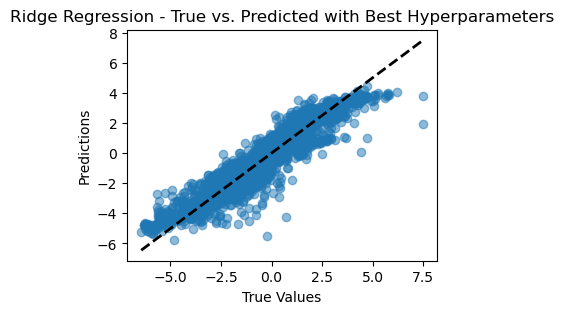

Elastic Regression Mean Absolute Error with Best Hyperparameters: 0.5942621909211065


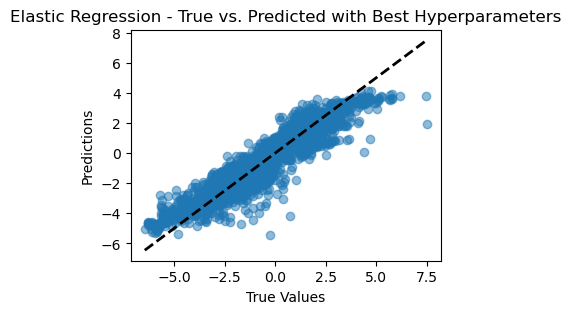

Kernel Ridge Regression Mean Absolute Error with Best Hyperparameters: 0.35707884135728174


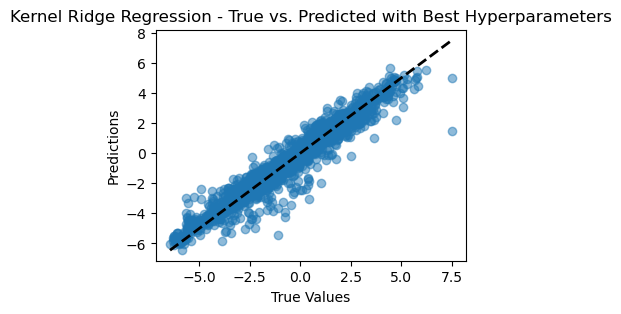


iemb:  1

Ridge Regression Mean Absolute Error with Best Hyperparameters: 1.0038593582430828


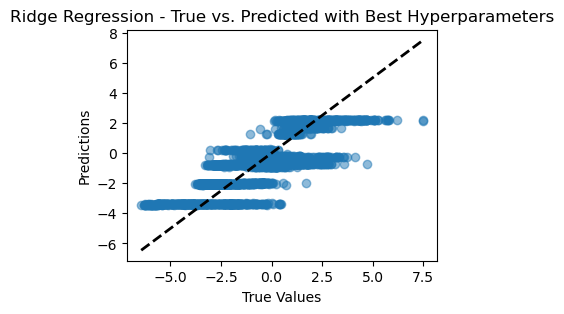

Elastic Regression Mean Absolute Error with Best Hyperparameters: 1.002037699128813


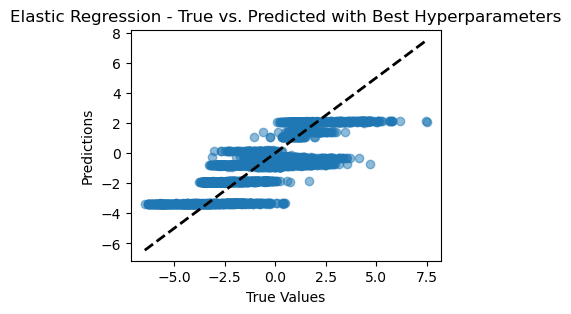

Kernel Ridge Regression Mean Absolute Error with Best Hyperparameters: 0.41760666951495246


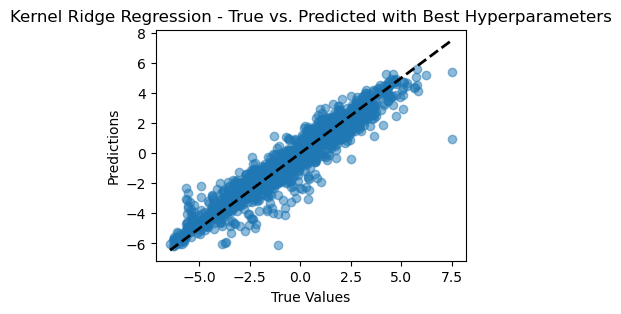


iemb:  2

Ridge Regression Mean Absolute Error with Best Hyperparameters: 0.8298995026478054


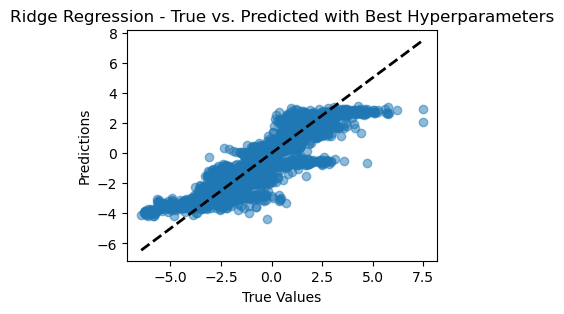

Elastic Regression Mean Absolute Error with Best Hyperparameters: 0.8288610246940675


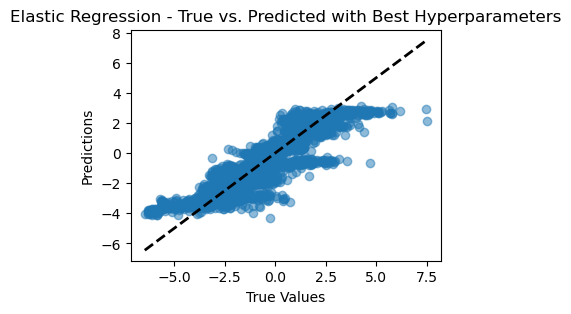

In [ ]:
# Tune hyperparameters and train models
for iemb, (X_train, X_test) in enumerate([(X_train_org, X_test_org), (X_train_pca, X_test_pca), (X_train_siamese, X_test_siamese)]):
    print()
    print('=================================================')
    print('iemb: ', iemb)
    print('=================================================')
    print()
    for name, model_info in models.items():
        grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring='neg_mean_absolute_error', cv=5)
        grid_search.fit(X_train, y_train)  # Changed to X_train instead of X_train_pca

        # Use the best model for predictions
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)  # Changed to X_test instead of X_test_pca

        # Mean Absolute Error
        mae = mean_absolute_error(y_test, y_pred)
        print(f"{name} Mean Absolute Error with Best Hyperparameters: {mae}")

        # Plot true vs. predicted values
        plt.figure(figsize=(4, 3))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.xlabel("True Values")
        plt.ylabel("Predictions")
        plt.title(f"{name} - True vs. Predicted with Best Hyperparameters")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.show()

In [ ]:
## do: (ocp) x (ridge, elastic, krr, svr) x (org, pca, siamese)

In [ ]:
# Separate features and targets
X_train = df_train_ocp1.iloc[:, 2:-1]
y_train = df_train_ocp1.iloc[:, -1]
X_test = df_test_ocp1.iloc[:, 2:-1]
y_test = df_test_ocp1.iloc[:, -1]

In [ ]:
# Standardize the features
scaler_X = StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)
X_test_std = scaler_X.transform(X_test)

In [ ]:
## original

X_train_org = X_train_std
X_test_org = X_test_std

In [ ]:
## pca - Apply PCA and retain 90% variance
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
print('X_train_pca shape: ', X_train_pca.shape)

In [ ]:
## siamese

len_embedding, abstract_len_embedding = int(X_train_org.shape[1]), int(X_train_pca.shape[1])
print('len_embedding, abstract_len_embedding: ', len_embedding, abstract_len_embedding)

# Combine both lists of DataFrames
all_dfs = list_env_train_cat1 + list_env_train_ocp1

# Initialize empty lists for all feature data and target data
all_feature_data = []
all_target_data = []

# Iterate over the combined list of DataFrames and create comparison data
for dataframe in all_dfs:
    feature_data, target_data = create_comparison_data(dataframe)
    all_feature_data.extend(feature_data)
    all_target_data.extend(target_data)

# Convert lists to arrays
X_senv = np.array(all_feature_data)
y_senv = np.array(all_target_data)

print('X_senv shape, y_senv shape: ', X_senv.shape, y_senv.shape)

scaler = StandardScaler().fit(X_senv)
X_senv_std = scaler.transform(X_senv)

fp1 = torch.tensor(X_senv_std[:, :len_embedding], dtype=torch.float32)
fp2 = torch.tensor(X_senv_std[:, len_embedding:], dtype=torch.float32)
y_tensor = torch.tensor(y_senv, dtype=torch.float32).unsqueeze(1)  # Convert y to tensor and add a dimension

dataset = TensorDataset(fp1, fp2, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

n_hidden_nodes = [8]
learning_rates = [0.01]
num_epochs = 100  # Adjust as necessary

best_model = None
lowest_error = float('inf')

for n_hidden_node in n_hidden_nodes:
    for lr in learning_rates:
        
        model = SiameseNetwork(len_embedding, abstract_len_embedding, n_hidden_node)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(num_epochs):
            if epoch % int(num_epochs/10) == 0:
                print(epoch)
            for batch_fp1, batch_fp2, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = model(batch_fp1, batch_fp2)
                loss = model.loss(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        # Calculate training error for the current hyperparameter combination
        with torch.no_grad():
            all_outputs = model(fp1, fp2)
            train_error = model.loss(all_outputs, y_tensor).item()
        
        # Update best model and lowest error if needed
        if train_error < lowest_error:
            lowest_error = train_error
            best_model = model

print(f"Best Model has a training error of: {lowest_error}")

X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_std, dtype=torch.float32)

# Use the model to transform the data
X_train_siamese_tensor = best_model.nn_reg(X_train_tensor)
X_test_siamese_tensor = best_model.nn_reg(X_test_tensor)

# Convert the output tensors to NumPy arrays
X_train_siamese = X_train_siamese_tensor.detach().numpy()
X_test_siamese = X_test_siamese_tensor.detach().numpy()

print('X_train_siamese shape, X_test_siamese shape', X_train_siamese.shape, X_test_siamese.shape)

In [ ]:
# Display mean absolute value of the target
mean_absolute_target = y_test.abs().mean()
print(f"Mean Absolute Value of Target: {mean_absolute_target}")

In [ ]:
# Tune hyperparameters and train models
for iemb, (X_train, X_test) in enumerate([(X_train_org, X_test_org), (X_train_pca, X_test_pca), (X_train_siamese, X_test_siamese)]):
    print()
    print('=================================================')
    print('iemb: ', iemb)
    print('=================================================')
    print()
    for name, model_info in models.items():
        grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring='neg_mean_absolute_error', cv=5)
        grid_search.fit(X_train, y_train)  # Changed to X_train instead of X_train_pca

        # Use the best model for predictions
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)  # Changed to X_test instead of X_test_pca

        # Mean Absolute Error
        mae = mean_absolute_error(y_test, y_pred)
        print(f"{name} Mean Absolute Error with Best Hyperparameters: {mae}")

        # Plot true vs. predicted values
        plt.figure(figsize=(4, 3))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.xlabel("True Values")
        plt.ylabel("Predictions")
        plt.title(f"{name} - True vs. Predicted with Best Hyperparameters")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.show()